In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [3]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [4]:
column_to_predict = "kg_CO2/kWh"

independent_variables = []

for column in train:
    if abs(train[column].corr(train[column_to_predict])) > THRESHOLD:
        independent_variables.append(column)

independent_variables.remove(column_to_predict)
if "Index" in independent_variables:
    independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Hour_2',
 'Hour_3',
 'Occupant Count (people)_3',
 '12h Outdoor Drybulb Temperature (C)',
 '24h Outdoor Drybulb Temperature (C)',
 '12h Outdoor Relative Humidity (%)',
 '6h Direct Solar Radiation (W/m2)',
 '12h Direct Solar Radiation (W/m2)']

Prepare the data

In [5]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[column_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[column_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[column_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [6]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [7]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24)
X_val = (25, 48, 9), Y_val = (25, 24)
X_test = (25, 48, 9), Y_test = (25, 24)


In [8]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []

model = keras.Sequential([
    keras.layers.LSTM(48, activation='relu', input_shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES), return_sequences=True),
    # keras.layers.Dropout(0.2),   no dropout yet
    keras.layers.LSTM(48, activation='relu', return_sequences=True),
    keras.layers.LSTM(24, activation='relu', return_sequences=False),
    keras.layers.Dense(24)
]) #amount of layers & neurons to be adjusted


model.compile(
    optimizer='adam',
    loss= 'mse'
) #types of optimizer, loss function to be adjusted

for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y_train_current_split,
              epochs=200, 
              validation_data=(X_test_current_split, y_test_current_split),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])

Epoch 1/200
4/4 [==============================] - 3s 168ms/step - loss: 0.4045 - val_loss: 0.2084
Epoch 2/200
4/4 [==============================] - 0s 35ms/step - loss: 0.3668 - val_loss: 0.1805
Epoch 3/200
4/4 [==============================] - 0s 35ms/step - loss: 0.3137 - val_loss: 0.2435
Epoch 4/200
4/4 [==============================] - 0s 36ms/step - loss: 0.2776 - val_loss: 0.1446
Epoch 5/200
4/4 [==============================] - 0s 36ms/step - loss: 0.2442 - val_loss: 0.1427
Epoch 6/200
4/4 [==============================] - 0s 35ms/step - loss: 0.2155 - val_loss: 0.1546
Epoch 7/200
4/4 [==============================] - 0s 37ms/step - loss: 0.1853 - val_loss: 0.1186
Epoch 8/200
4/4 [==============================] - 0s 39ms/step - loss: 0.1637 - val_loss: 0.1299
Epoch 9/200
4/4 [==============================] - 0s 35ms/step - loss: 0.1480 - val_loss: 0.1093
Epoch 10/200
4/4 [==============================] - 0s 34ms/step - loss: 0.1318 - val_loss: 0.1129
Epoch 11/200
4/4 [

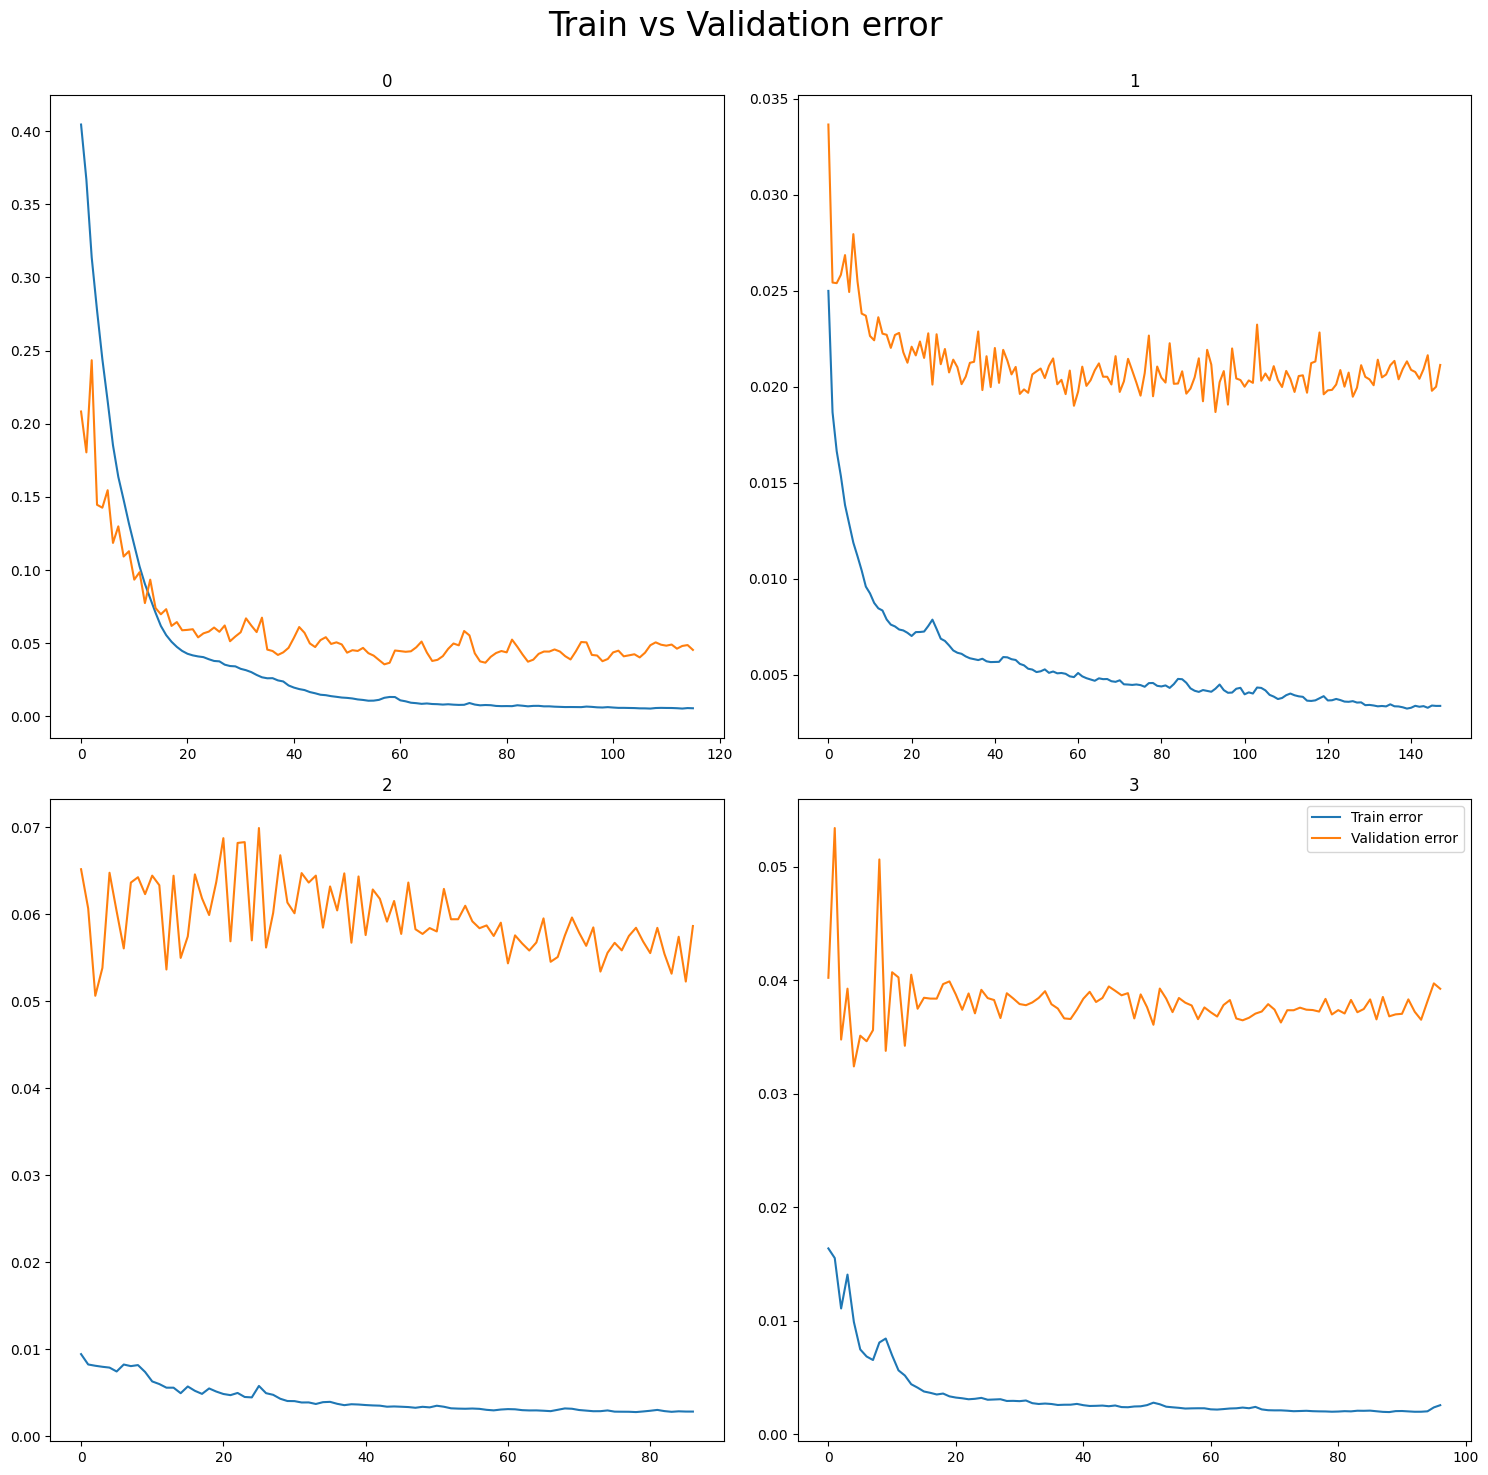

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [10]:
# Evaluate the model on the test data
predictions = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred = model.predict(current_batch)
    predictions.append(curr_pred)

1/1 [==============================] - 0s 21ms/step


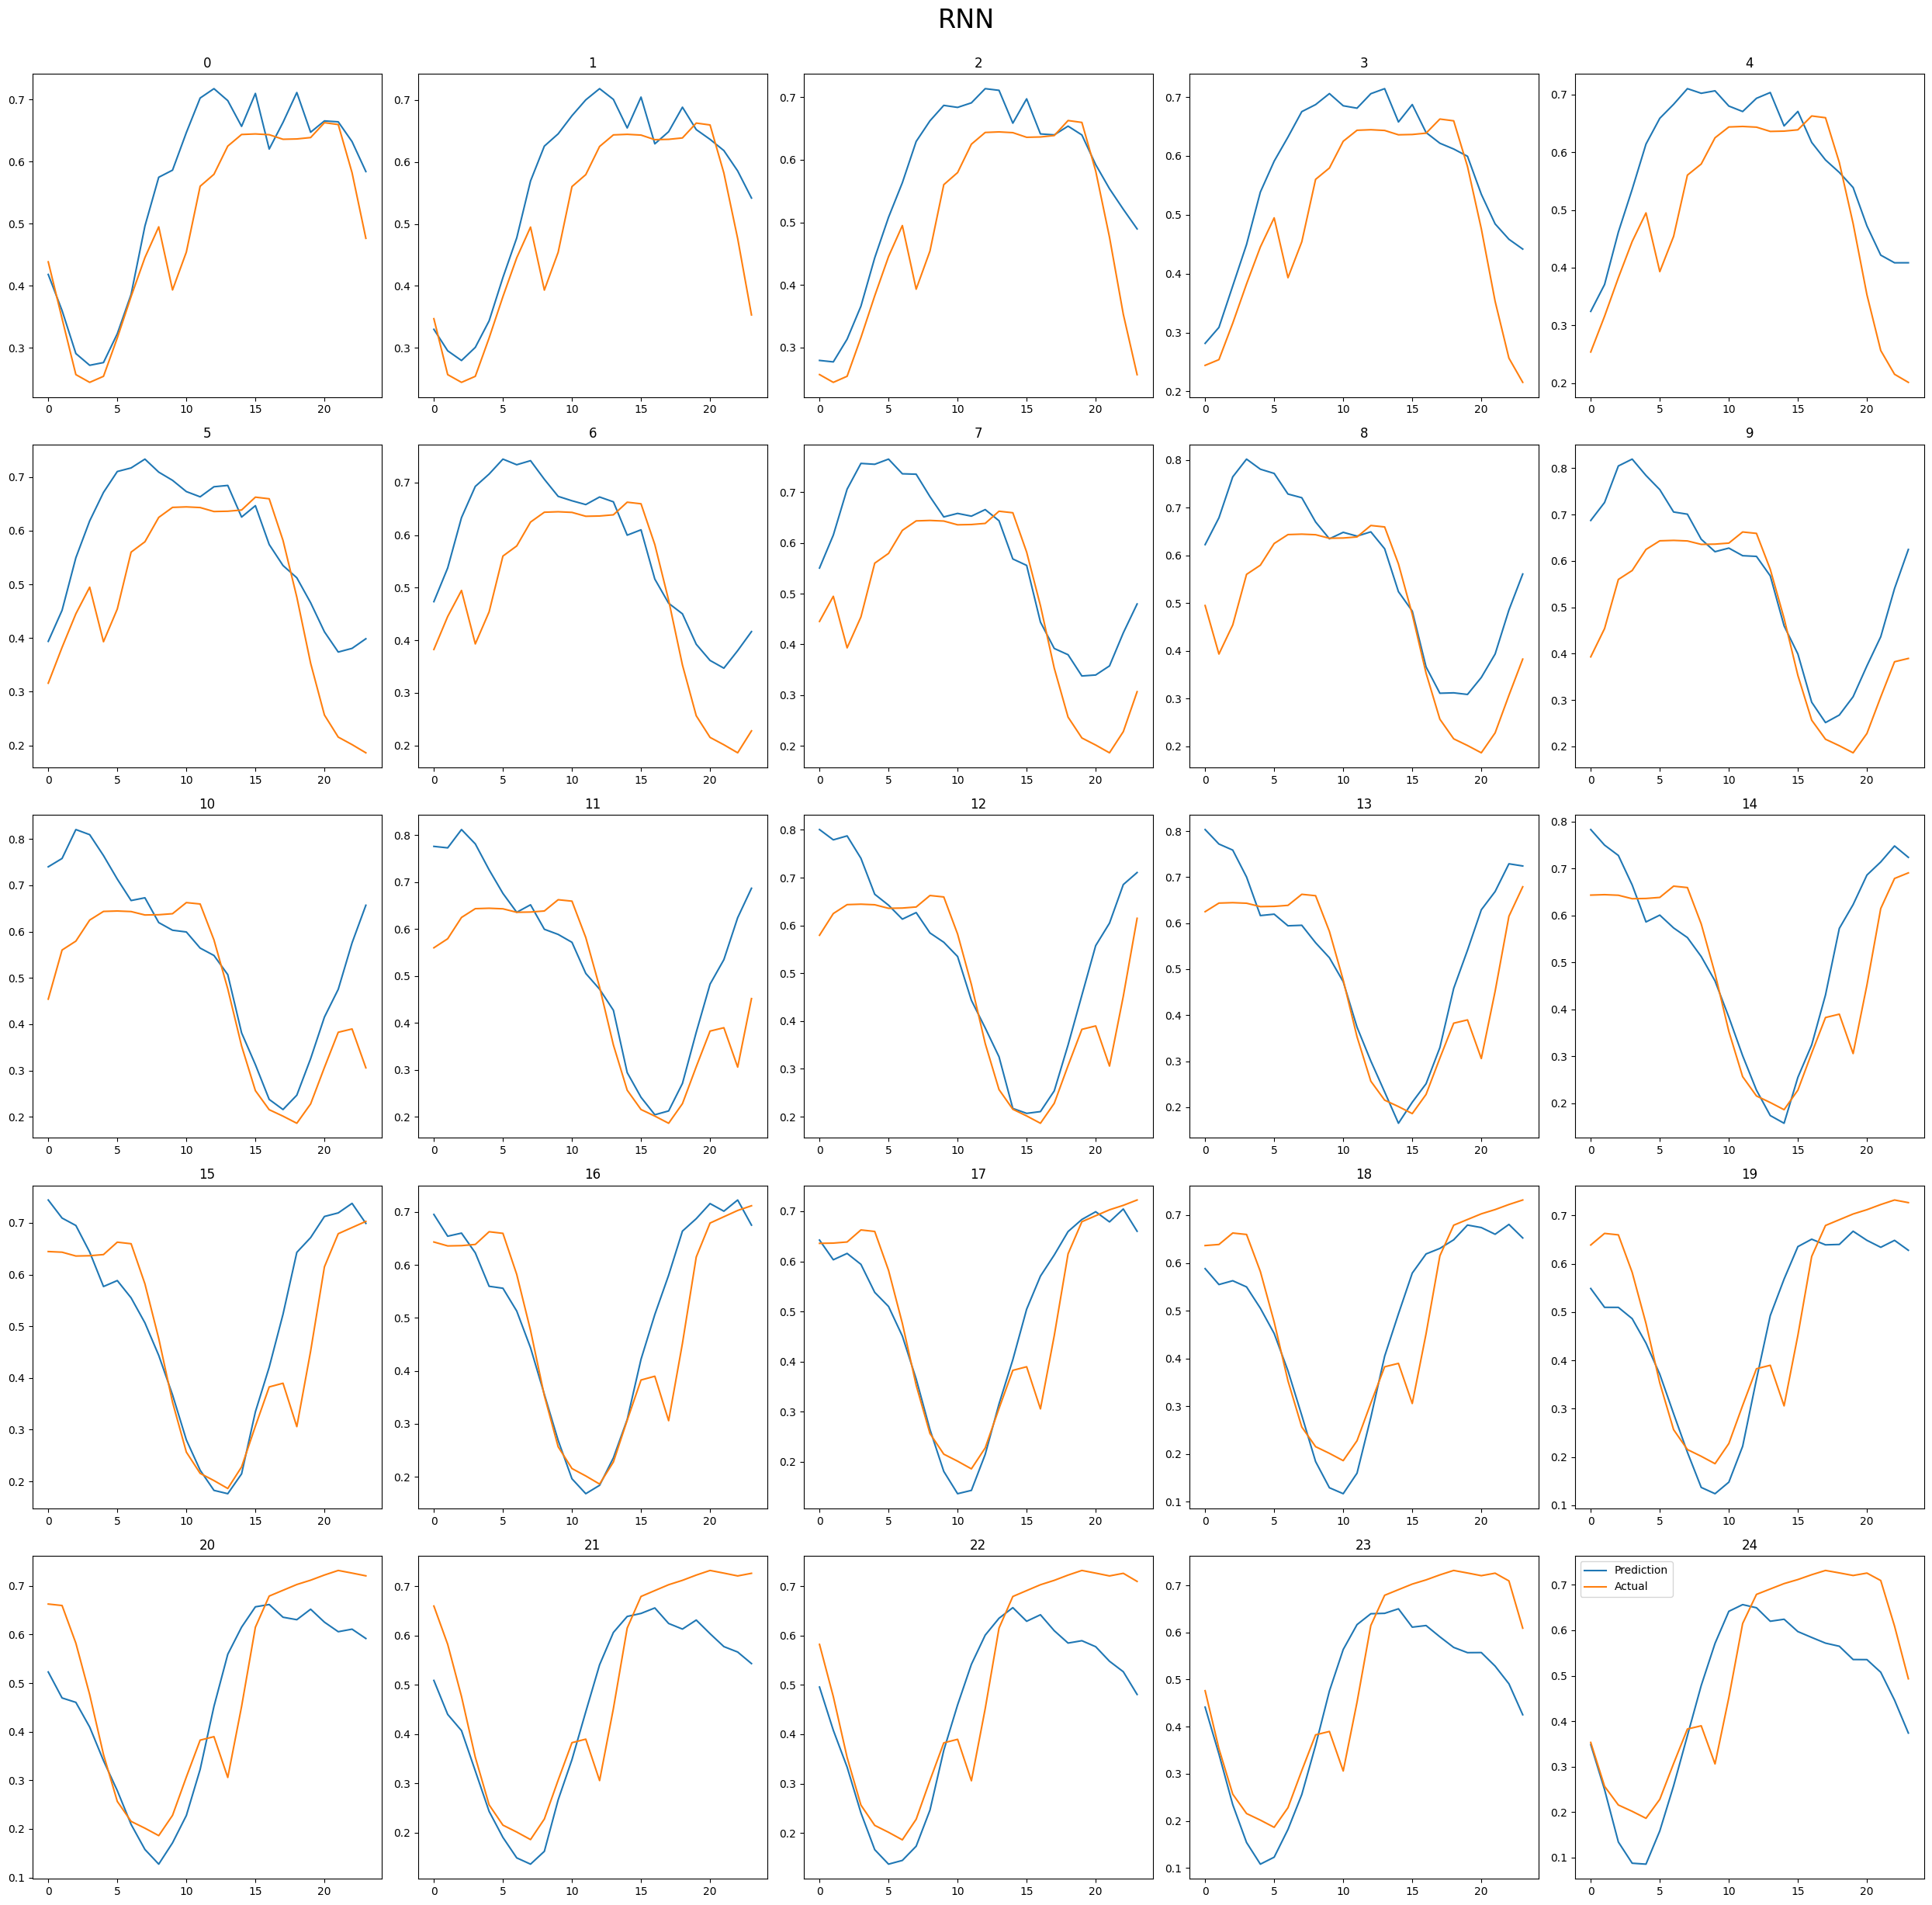

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = 0
for i in range(len(predictions)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions[i][0], Y_val[i]))}')
    rmse += sqrt(mean_squared_error(predictions[i][0], Y_val[i]))

rmse /= len(predictions)    
print(f"RMSE = {rmse}")

pred=0, num = 0.08071141264446825
pred=1, num = 0.09116697374296873
pred=2, num = 0.10256312425792605
pred=3, num = 0.11230756021274454
pred=4, num = 0.12017413075912388
pred=5, num = 0.12816241463514477
pred=6, num = 0.13354218193247935
pred=7, num = 0.14009246785346538
pred=8, num = 0.14055423988584667
pred=9, num = 0.14016510709491706
pred=10, num = 0.13645092320744603
pred=11, num = 0.12422325942934019
pred=12, num = 0.1150421761841867
pred=13, num = 0.10920522673953093
pred=14, num = 0.10801068129024305
pred=15, num = 0.10031360744482144
pred=16, num = 0.08580845587743077
pred=17, num = 0.07927763895258023
pred=18, num = 0.08703569545378595
pred=19, num = 0.09929663305973427
pred=20, num = 0.10368875680893144
pred=21, num = 0.10540869408783031
pred=22, num = 0.11417312579483588
pred=23, num = 0.12350246686886239
pred=24, num = 0.12934408806396444
RMSE = 0.11240884169130436
